In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from shapely import geometry
from shapely.ops import unary_union
from shapely.geometry import Point
from descartes.patch import PolygonPatch
from skipper import tiling
from astropy import coordinates

In [3]:
def evaluate_coverage (frd, grid, poly_l ):
    RA,DEC = np.meshgrid ( frd.grid_ra, frd.grid_dec )

    in_cosmos = (RA >= (frd.center[0] - size[0]/2))&(RA <= (frd.center[0] + size[0]/2))
    in_cosmos &= (DEC >= (frd.center[1] - size[1]/2))&(DEC <= (frd.center[1] + size[1]/2))

    total_area_covered = unary_union(poly_l).area
    cy_l = []
    for ix,cnexp in enumerate([0, 10, 20, 30, 35, 39]):
        cy = (grid.sum(axis=0)[in_cosmos] > cnexp).sum()/in_cosmos.sum()   
        cy_l.append(cy)
    return total_area_covered, cy_l

In [4]:
def plot ( frd, grid, vmax=40 ):
    plt.figure(figsize=(8,6))
    ax = plt.subplot(111, aspect='equal')

    plt.pcolormesh(frd.grid_ra - np.diff(frd.grid_ra)[0]*.5, 
                   frd.grid_dec - np.diff(frd.grid_dec)[0]*.5, 
                   grid.sum(axis=0).T, vmax=vmax, vmin=0)

    rect = patches.Rectangle ( [frd.center[0] - size[0]/2, frd.center[1] - size[1]/2],
                              width = size[0], 
                              height= size[1],
                             fc='None', ec='w', )
    ax.add_patch (rect)
    #ax.text ( .95, 0.95, r'$\Delta$R=%.2f deg' % (radii_a[ix]*size[0]), ha='right', va='top', color='white', 
    #        fontsize=20, transform=ax.transAxes )
    plt.colorbar(label=r'$\rm N_{exp}$')
    ax.set_xlabel('RA (deg)')
    ax.set_xlim (ax.get_xlim()[::-1])
    ax.set_ylabel ( "Dec (deg)")

    #plt.savefig(f'../../scratch/figs/{ix:04d}.png')
    #plt.close()


First, let's define the COSMOS target area

In [5]:
# \\ COSMOS region
center = coordinates.SkyCoord ("10h00m28.6s+02d12m21.0s")
size =  (1.4, 1.4)

edges = [ (center.ra.deg-size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg-size[0]/2.),
          (center.ra.deg+size[0]/2., center.dec.deg+size[0]/2.),
          (center.ra.deg-size[0]/2., center.dec.deg+size[0]/2.) ]
cosmos_area = geometry.Polygon ( edges )

Now, for the circular FOV, find the area coverage

In [6]:
#or_l = np.linspace(0., 0.125,15)
#tac_a = np.zeros ( len(or_l) )
#cy_a = np.zeros ( [len(or_l), 6] )
#
#for ix,cor in enumerate(or_l):
#    frd = tiling.FocusedRandomDither (center, offset_radius=cor)
#    frd._make_grid ()
#
#    poly_l, area_a, centers = frd.compute_coverage ( cosmos_area )
#    #tac, cy_l = evaluate_coverage ( frd, frd, poly_l )
#    
#    tac_a[ix] = tac
#    cy_a[ix] = cy_l
#    plot(frd, poly_l)
#    plt.savefig(f'../../scratch/figs/RD{ix:04d}.png')
#    plt.close()

In [8]:
np.random.seed(246)
frd = tiling.FocusedRandomDither (center, offset_radius=0.08, ndither=4)
frd._make_grid ()
poly_l, area_a, centers = frd.compute_coverage ( cosmos_area )

Text(0, 0.5, 'Dec (deg)')

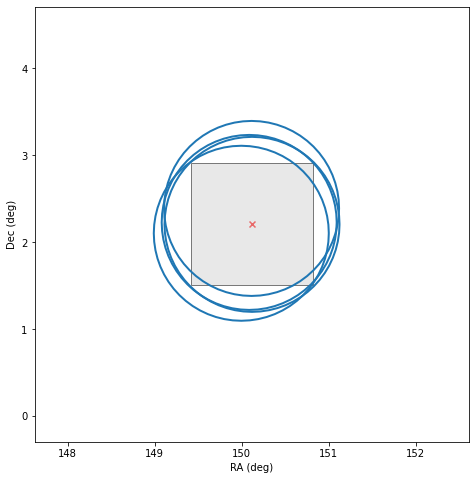

In [9]:
fig = plt.figure ( figsize=(8,8))
ax = plt.subplot(111, aspect='equal')
rect = patches.Rectangle ( [center.ra.deg - size[0]/2, center.dec.deg - size[1]/2],
                          width = size[0], 
                          height= size[1],
                         fc='lightgrey', ec='k', alpha=0.5)
ax.add_patch (rect)

for ij in range(frd.ndither):
    patch = PolygonPatch ( poly_l[ij], fc='None', ec='tab:blue', lw=2, )
    ax.add_patch(patch)
    
ax.scatter ( *frd.center, color='r', marker='x')

ax.set_xlim ( center.ra.deg - 2.5,  center.ra.deg  + 2.5)
ax.set_ylim ( center.dec.deg- 2.5,  center.dec.deg + 2.5)

ax.set_xlabel ( 'RA (deg)')
ax.set_ylabel ('Dec (deg)')

OK, how about if we use the real DECam FOV?

In [10]:
from schwimmbad import MultiPool
from shapely.strtree import STRtree 
from shapely import affinity

In [11]:
%load_ext line_profiler

In [213]:
#np.random.seed(246)
frd = tiling.FocusedRandomDither (center, random_max=0.1, offset_radius=0.0, start_at_center=True, ndither=40)
frd._make_grid (ngridstep=300, extent=1.25)
rotate = False

In [214]:
%%capture
poly_l, area_a, centers = frd.compute_coverage ( cosmos_area, footprint=frd.decam_fp, rotate=False )
mpoly = unary_union ( poly_l )

In [221]:
tree = STRtree ( poly_l[4:8] )

In [222]:
anycoverage = [ mpoly.contains(ix) for ix in frd.gridpoints ] 

In [223]:
def coverage_fn ( data ):
    query_geom, has_any_coverage = data
    if not has_any_coverage:
        return 0
    overlaps = [ branch for branch in tree.query( query_geom ) if branch.contains ( query_geom ) ]
    return len(overlaps)


In [224]:
%%time
data = np.stack([frd.gridpoints, anycoverage]).T
with MultiPool() as pool:
    values = list(pool.map(coverage_fn, data) )

CPU times: user 4.4 s, sys: 299 ms, total: 4.7 s
Wall time: 27.4 s


In [225]:
save=False

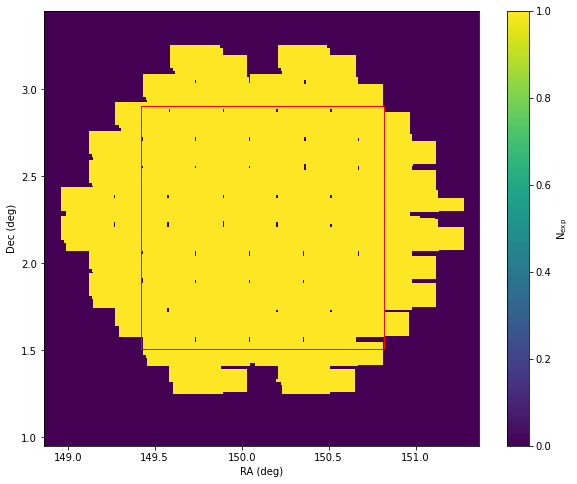

In [226]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, aspect='equal')
if rotate:
    name = 'rotate_uighres'
else:
    name = 'norotate_uhighres'

cvmap = np.asarray(values).reshape(frd.grid_ra.size, frd.grid_dec.size).T

plt.pcolormesh(frd.grid_ra - np.diff(frd.grid_ra)[0]*.5, 
               frd.grid_dec - np.diff(frd.grid_dec)[0]*.5, 
               cvmap>0, vmin=0, vmax=1)


rect = patches.Rectangle ( [center.ra.deg - size[0]/2, center.dec.deg - size[1]/2],
                          width = size[0], 
                          height= size[1],
                          ec='r', fc='None', zorder=10)
ax.add_patch (rect)
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")


plt.colorbar(label=r'$\rm N_{exp}$')

if save:
    print(name)
    np.save( f'../../scratch/{name}_coverage.npy', cvmap )
    plt.savefig(f'../../scratch/figs/{name}_coverage.png')

In [232]:
from shapely import affinity

In [68]:
def get_gridpoints ( center, ngridstep, extent=1.25):
    gra_a = np.linspace(center[0] - extent,
                        center[0]  + extent, ngridstep)
    gdec_a = np.linspace(center[1] - extent,
                         center[1] + extent, ngridstep)    
    return gra_a, gdec_a

In [69]:
gra_a, gdec_a = get_gridpoints ( frd.center, 800)
RA,DEC = np.meshgrid ( gra_a, gdec_a )
in_cosmos_uhr = (RA >= (frd.center[0] - size[0]/2))&(RA <= (frd.center[0] + size[0]/2))
in_cosmos_uhr &= (DEC >= (frd.center[1] - size[1]/2))&(DEC <= (frd.center[1] + size[1]/2))

gra_a, gdec_a = get_gridpoints ( frd.center, 500)
RA,DEC = np.meshgrid ( gra_a, gdec_a )
in_cosmos_lr = (RA >= (frd.center[0] - size[0]/2))&(RA <= (frd.center[0] + size[0]/2))
in_cosmos_lr &= (DEC >= (frd.center[1] - size[1]/2))&(DEC <= (frd.center[1] + size[1]/2))

gra_a, gdec_a = get_gridpoints ( frd.center, 600)
RA,DEC = np.meshgrid ( gra_a, gdec_a )
in_cosmos_hr = (RA >= (frd.center[0] - size[0]/2))&(RA <= (frd.center[0] + size[0]/2))
in_cosmos_hr &= (DEC >= (frd.center[1] - size[1]/2))&(DEC <= (frd.center[1] + size[1]/2))

In [70]:
cgrid_l = [in_cosmos_hr, in_cosmos_hr,in_cosmos_hr,in_cosmos_hr, in_cosmos_lr]

In [71]:
tags = ['norotate_q','rotate_q','norotate_nooffset_q','rotate_nooffset_q','norotate_uhighres']
descriptions = ['no rotation', 'random uniform rotation (RUR)', 'no rotation, centered', 'RUR, centered',
               'no rotation, centered, high res', 'no rotation, centered, uhigh res']
coverage_d = {}


steps = np.arange(0,40,2)
cy_a = np.zeros([len(tags),len(steps)])
for iw,tag in enumerate(tags):
    cvmap = np.load(f'../../scratch/{tag}_coverage.npy')
    for ix,cnexp in enumerate(steps):
        cy = (cvmap[cgrid_l[iw]] > cnexp).sum()/cgrid_l[iw].sum()   
        cy_a[iw,ix] = cy

In [72]:
usable_frac = poly_l[1].area / 3.18

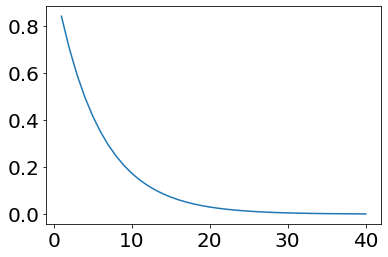

In [73]:
exps = np.arange(1,41)
plt.plot ( exps, np.power(usable_frac, exps) )

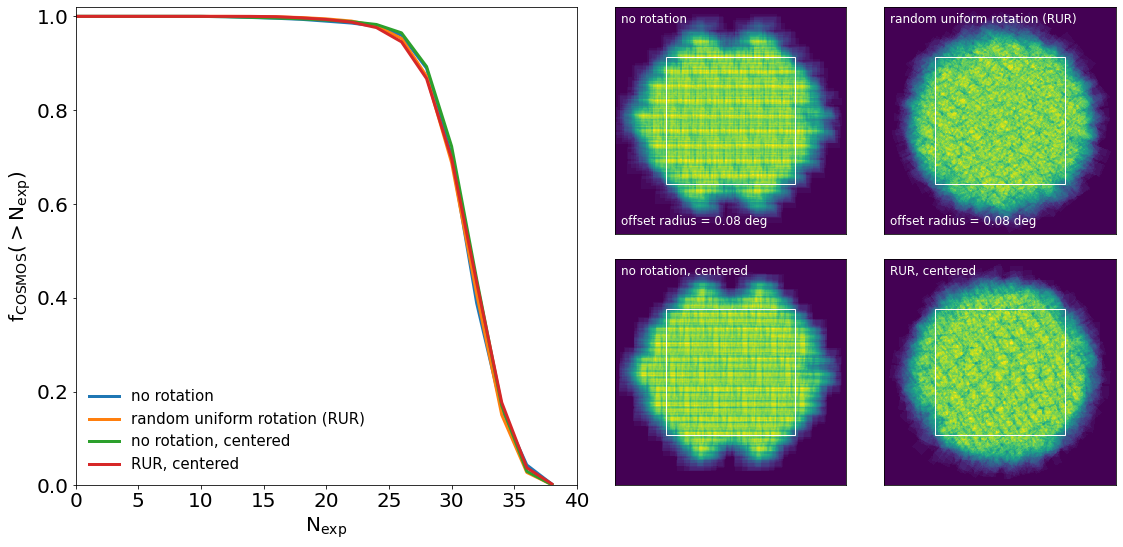

In [74]:
fig = plt.figure(figsize=(16,8))

shp = (2,4)
ax0 = plt.subplot2grid(shp, (0,0), rowspan=2, colspan=2 )
axim_l = []
for ia in range(2):
    for ib in range(2):
        axim_l.append ( plt.subplot2grid(shp,(ia,ib+2)) )
        
for iw,tag in enumerate(tags[:-1]):
    if iw == len(tags)-1:
        ls='--'
        color='grey'
    else:
        color=f'C{iw}'
        ls='-'
    ax0.plot ( steps, cy_a[iw], label=descriptions[iw], lw=3, color=color, ls=ls)
ax0.set_ylabel(r'$\rm f_{COSMOS}(>N_{exp})$') 
ax0.legend(frameon=False, fontsize=15)
ax0.set_xlabel(r'$\rm N_{exp}$')
ax0.set_xlim(0.,40.)
ax0.set_ylim(0.,1.02)

for ic,ax in enumerate(axim_l):
    tag = tags[ic]
    cvmap = np.load(f'../../scratch/{tag}_coverage.npy')
    ax.pcolormesh(gra_a, gdec_a, cvmap.astype(float))
    
    rect = patches.Rectangle ( [center.ra.deg - size[0]/2, center.dec.deg - size[1]/2],
                          width = size[0], 
                          height= size[1],
                          ec='w', fc='None', zorder=10)
    ax.add_patch (rect)
    
    ax.text(0.025, 0.975, descriptions[ic], ha='left', va='top', color=f'w', fontsize=12, transform=ax.transAxes )
    
    if ic < 2:
        ax.text(0.025, 0.025, 'offset radius = 0.08 deg', ha='left', va='bottom', 
                color=f'w', fontsize=12, transform=ax.transAxes )

    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout ()
plt.savefig('../figures/COSMOSRotationAnalysis.png')

In [75]:
from skymap.instrument.decam import DECamFocalPlane

decam = DECamFocalPlane ()

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (5).

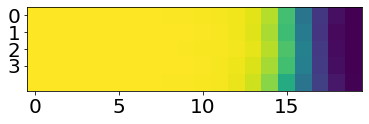

In [76]:
ax = plt.subplot(111)
plt.imshow(cy_a)
ax.set_yticks(range(4))
ax.set_yticklabels(tags)
plt.colorbar(orientation='horizontal', label=r'$\rm N_{exp}$')

/Users/kadofong/work/merian/skipper/python/skipper/tiling.py:164: DeprecationWarning: invalid escape sequence \%
  plt.text((blo+bhi)/2., ni, '%.1f \%%' % (100.*ni), ha='center', va='bottom', color='k')
/Users/kadofong/work/merian/skipper/python/skipper/tiling.py:166: DeprecationWarning: invalid escape sequence \%
  plt.text((blo+bhi)/2., ni-0.01, '%.1f \%%' % (100.*ni), ha='center', va='top', color='k')
/Users/kadofong/work/merian/skipper/python/skipper/tiling.py:167: DeprecationWarning: invalid escape sequence \%
  plt.text((blo+bhi)/2., nc, '%.1f \%%' % (100.*nc), ha='center', va='bottom', color='k')


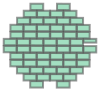

In [48]:
or_l = np.linspace(0., 0.125,15)
tac_a = np.zeros ( len(or_l) )
cy_a = np.zeros ( [len(or_l), 6] )

for ix,cor in enumerate(or_l):
    frd = tiling.FocusedRandomDither (center, offset_radius=cor)
    frd._make_grid ()

    grid, poly_l, area_a, centers = frd.compute_coverage ( cosmos_area, fov= )
    tac, cy_l = evaluate_coverage ( frd, grid, poly_l )
    
    tac_a[ix] = tac
    cy_a[ix] = cy_l
    plot(frd)
    plt.savefig(f'../../scratch/figs/RD{ix:04d}.png')
    plt.close()

In [39]:
corners = np.asarray(decam.ccd_dict[1])

In [41]:
corners[:,0]

array([-0.45778385, -0.45828909, -0.15912774, -0.15868303])

In [27]:
from skymap.instrument.decam import DECamFocalPlane

In [14]:
decam = DECamFocalPlane ()

/Users/kadofong/env3/lib/python3.7/site-packages/skymap/instrument/decam.py:21: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/kadofong/env3/lib/python3.7/site-packages/skymap/data/ccd_corners_xy_fill.dat' mode='r' encoding='UTF-8'>
  self.ccd_dict = eval(''.join(open(self.filename).readlines()))


In [18]:
ccd_l = [ geometry.Polygon ( decam.ccd_dict[xi] ) for xi in decam.ccd_dict.keys() ]

In [19]:
ccd_mpoly = unary_union ( ccd_l )